### Dataset :
The dataset is a French retail company quarterly sales data that has been made available from  Prof. Rob Hyndman's ["Forecasting Methods & Applications"](https://robjhyndman.com/forecasting/) book. There are 24 entries, from 2012-03-31 to 2017-12-31 (Quarterly sales values).

In [16]:
#Download Dataset
!wget -qq https:// #load your dataset

### Importing libraries


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
np.random.seed(42)

### Import the Data

In [17]:
# Read dataset with 'Date' as index
df = pd.read_csv('ts_frenchretail.csv', parse_dates=['Date'], index_col='Date')
print(df.shape)
df.head()

(24, 1)


,Sales
Date,
2012-03-31,362000
2012-06-30,385000
2012-09-30,432000
2012-12-31,341000
2013-03-31,382000


## Exploratory Data Analysis

#### Divide the sales by 1000

Sales numbers are in thousands, so divide by 1000 to make it easier to work with numbers

In [18]:
df['Sales'] = df["Sales"] / 1000
df.head()

,Sales
Date,
2012-03-31,362.0
2012-06-30,385.0
2012-09-30,432.0
2012-12-31,341.0
2013-03-31,382.0


In [19]:
df.isna().sum() #check for missing values

,0
Sales,0


### **Visualization**

#### Visualize the time series (2012 to 2017)

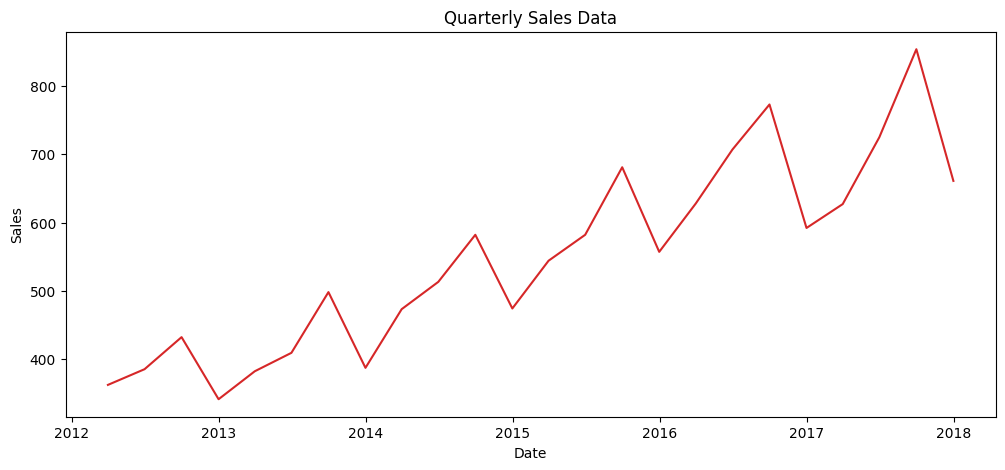

In [20]:
# Define function to plot the time series
def plot_df(x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(12, 5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_df(x=df.index, y=df["Sales"],
        title='Quarterly Sales Data')

#### Visualize the data year-wise and quarter-wise


In [21]:
# Prepare data
df.reset_index(inplace=True)

df['year'] = [d.year for d in df["Date"]]
df['month_name'] = [d.month_name() for d in df["Date"]]
df['month'] = [d.month for d in df["Date"]]
# Extracting quarter
df['quarter'] = df['Date'].dt.quarter
years = df['year'].unique()

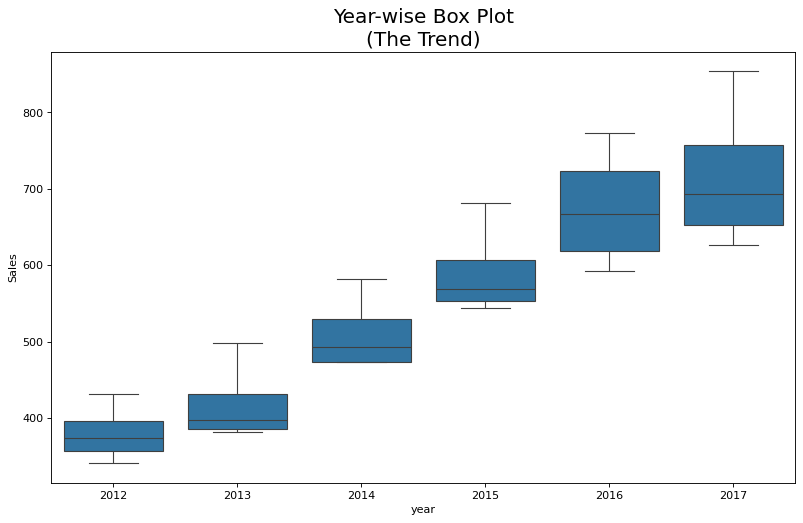

In [22]:
# Box plot to see distribution of sales in each year
# Visualize the yearly and monthly drug sales using box plot
fig, axes = plt.subplots(figsize=(12, 7), dpi=80)
sns.boxplot(x='year', y='Sales', data=df, ax=axes)

# Set title
axes.set_title('Year-wise Box Plot\n(The Trend)', fontsize=18)
plt.show()

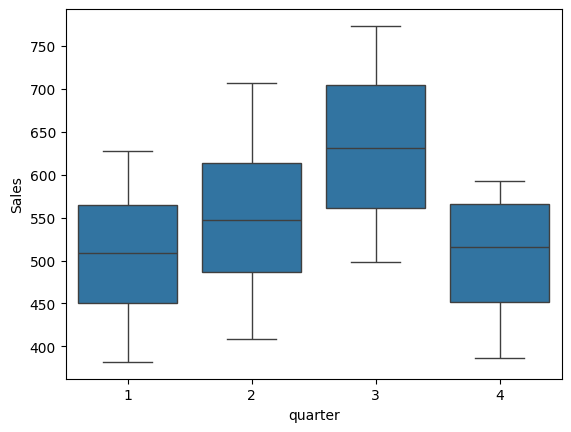

In [23]:
# Create year-wise subplots to visualize the quarterly Sales per year
sns.boxplot(x='quarter', y='Sales',
            data=df.loc[~df.year.isin([2012, 2017]), :])

# Set title
axes.set_title('Quarter-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [24]:
# Percentage growth each year
print(df.shape)
df.head()

(24, 6)


,Date,Sales,year,month_name,month,quarter
0,2012-03-31,362.0,2012,March,3,1
1,2012-06-30,385.0,2012,June,6,2
2,2012-09-30,432.0,2012,September,9,3
3,2012-12-31,341.0,2012,December,12,4
4,2013-03-31,382.0,2013,March,3,1


In [25]:
# Group the year and sum sales
yearly_sales = df.groupby('year')['Sales'].sum().reset_index()
yearly_sales

,year,Sales
0,2012,1520.0
1,2013,1676.0
2,2014,2042.0
3,2015,2364.0
4,2016,2700.0
5,2017,2867.0


In [26]:
yearly_sales['prct_growth'] = yearly_sales['Sales'].pct_change()*100
yearly_sales.head()

,year,Sales,prct_growth
0,2012,1520.0,NaN
1,2013,1676.0,10.263158
2,2014,2042.0,21.837709
3,2015,2364.0,15.768854
4,2016,2700.0,14.213198


#### Visualize the distribution of the Sales



<Axes: xlabel='Sales', ylabel='Count'>

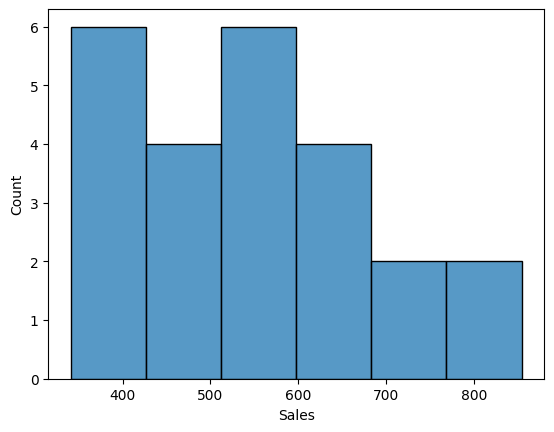

In [27]:
sns.histplot(data=df["Sales"])

#### Visualize Quarterly trends

In [28]:
df.head()

,Date,Sales,year,month_name,month,quarter
0,2012-03-31,362.0,2012,March,3,1
1,2012-06-30,385.0,2012,June,6,2
2,2012-09-30,432.0,2012,September,9,3
3,2012-12-31,341.0,2012,December,12,4
4,2013-03-31,382.0,2013,March,3,1


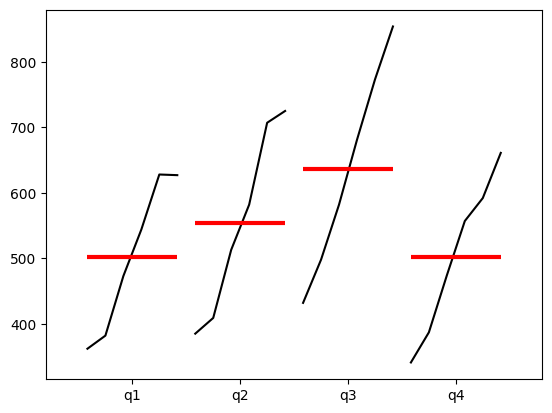

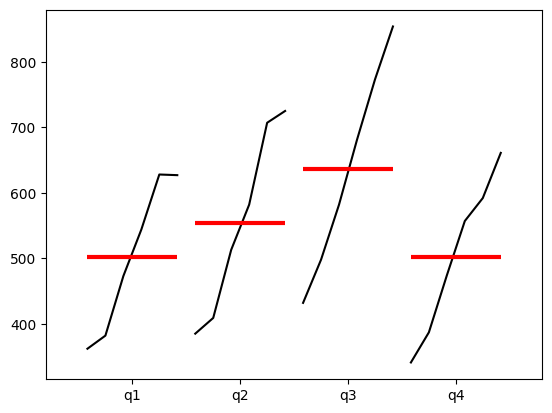

In [31]:
# Setting index back to date
df = df.set_index('Date')
quarter_plot(df["Sales"])

#### Visualize the distribution of Sales in each year within a single plot

In [33]:
print(df.shape)
df.head()

(24, 5)


,Sales,year,month_name,month,quarter
Date,,,,,
2012-03-31,362.0,2012,March,3,1
2012-06-30,385.0,2012,June,6,2
2012-09-30,432.0,2012,September,9,3
2012-12-31,341.0,2012,December,12,4
2013-03-31,382.0,2013,March,3,1


In [34]:
print(yearly_sales.shape)
yearly_sales.head()

(6, 3)


,year,Sales,prct_growth
0,2012,1520.0,NaN
1,2013,1676.0,10.263158
2,2014,2042.0,21.837709
3,2015,2364.0,15.768854
4,2016,2700.0,14.213198


<Axes: xlabel='Sales', ylabel='Count'>

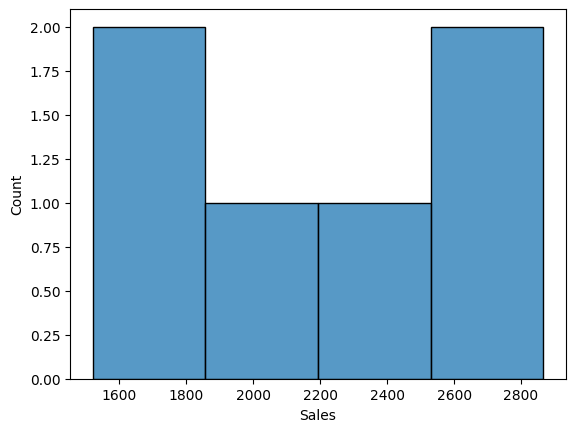

In [35]:
# Distribution plot of each year
sns.histplot(data=yearly_sales["Sales"])

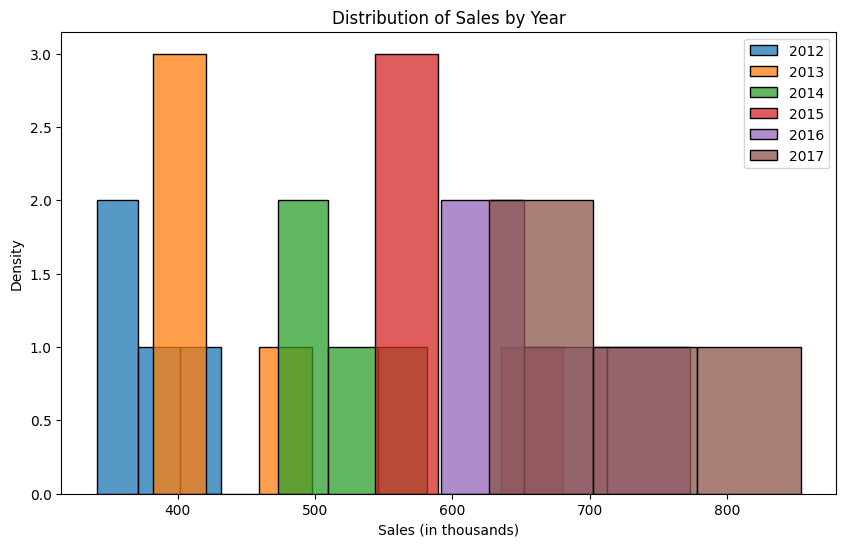

In [36]:
plt.figure(figsize=(10, 6))
for year in df['year'].unique():
    sns.histplot(df[df['year'] == year]['Sales'], label=year)
plt.xlabel('Sales (in thousands)')
plt.ylabel('Density')
plt.title('Distribution of Sales by Year')
plt.legend()
plt.show()

#### Visualize the patterns in time series - trend, seasonality, residuals


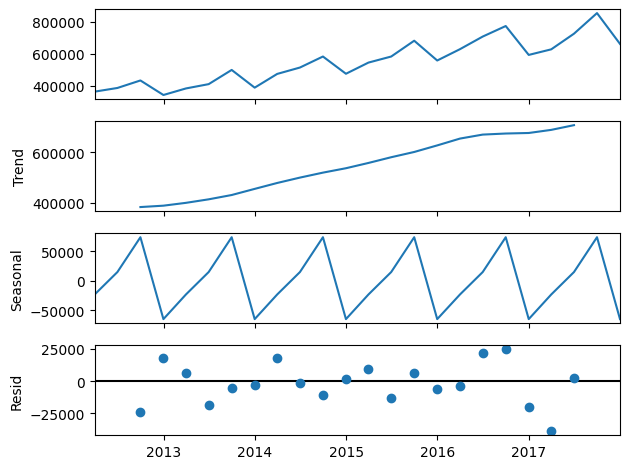

In [37]:
# Applying seasonal decompose
# Setting index back to date
df = pd.read_csv('ts_frenchretail.csv', parse_dates=['Date'], index_col='Date')

# Applying seasonal decompose
result = seasonal_decompose(df, model='additive')

# Plotting trend, seasonality and both trend and seasonality in drug sales data
result.plot()
plt.show()

### **Detrending the time series**

Text(0.5, 1.0, 'Quarterly Sales')

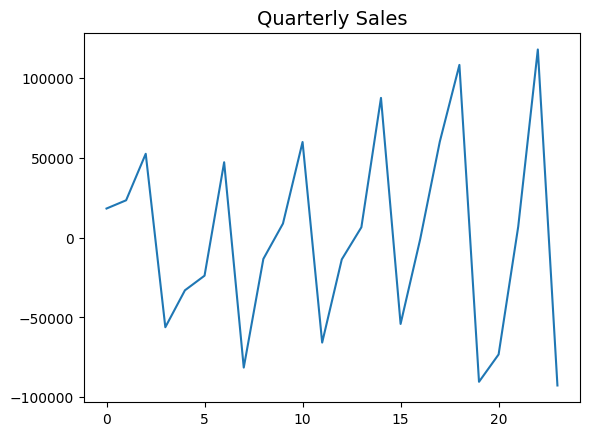

In [38]:
# Using scipy: Subtract the line of best fit
detrended = signal.detrend(df["Sales"].values)
plt.plot(detrended)
plt.title('Quarterly Sales', fontsize=14)

Text(0.5, 1.0, 'Quarterly Sales detrended by subtracting the trend component')

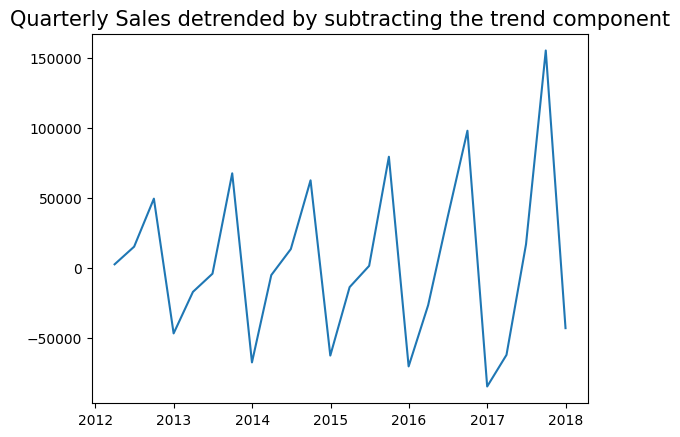

In [39]:
# Decomposing time-series first
result_mul = seasonal_decompose(
    df['Sales'], model='multiplicative', extrapolate_trend='freq')
# Detrending the time-series by trend component
detrended = df["Sales"].values - result_mul.trend

# Plotting the detrended time series
plt.plot(detrended)
plt.title('Quarterly Sales detrended by subtracting the trend component', fontsize=15)

In [40]:
# Time Series Decomposition
result_mul = seasonal_decompose(
    df['Sales'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize the time series
deseasonalized = df.Sales.values / result_mul.seasonal

[]

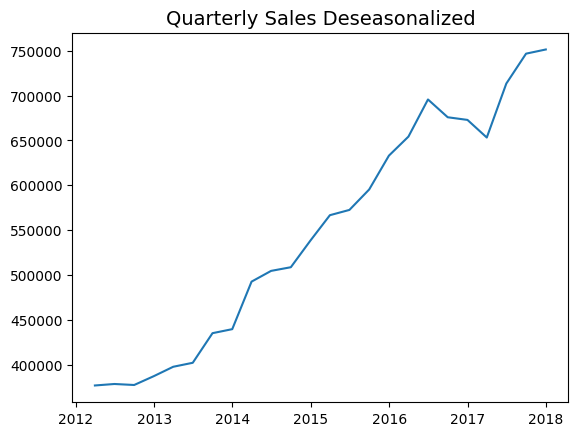

In [41]:
# Visualize deseasonalize tiem series
plt.plot(deseasonalized)
plt.title('Quarterly Sales Deseasonalized', fontsize=14)
plt.plot()

#### Visualize the Lag plots

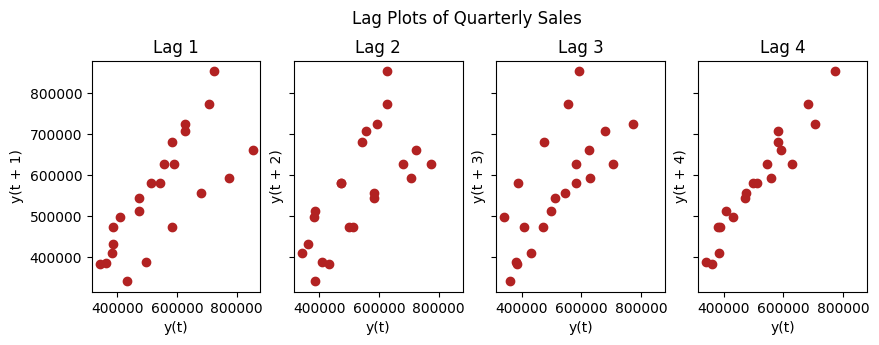

In [42]:
# Visualize lag plots
fig, axes = plt.subplots(1, 4, figsize=(
    10, 3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df["Sales"], lag=i+1, ax=ax, c='firebrick')
    ax.set_title(f'Lag {str(i+1)}')

fig.suptitle("Lag Plots of Quarterly Sales", y=1.05)
plt.show()

### Report Analysis

**Data Overview**

Quarterly sales data from a French retail company
Time period: 2012-03-31 to 2017-12-31 (24 quarters)
Data frequency: Quarterly
Main variable: Sales (in thousands)


**Trend Analysis**

Overall upward trend in sales from 2012 to 2017
Year-over-year growth shows consistent positive progression
Sales values have been steadily increasing across the years
The trend component from decomposition confirms a clear upward trajectory


**Seasonal Patterns**

Strong quarterly seasonality present in the data
Clear repeating patterns across years
Quarter-wise analysis shows:

Higher sales typically in Q4 (likely due to holiday season)
Lower sales generally in Q1 (post-holiday period)
Consistent seasonal pattern maintains throughout the years

**Distribution Characteristics**

Sales distribution shows slight positive skewness
Year-wise distributions reveal:

Increasing median sales values over years
Wider spread in later years indicating more variability
Each year's distribution maintains similar shape despite increasing values

**Time Series Components**

*Through decomposition analysis*

**Trend:** Strong upward trend

**Seasonality:** Consistent quarterly patterns

**Residuals:**
- Relatively small compared to trend and seasonal components
- Multiplicative decomposition shows better fit than additive


**Lag Analysis:**
- Strong positive autocorrelation at lag 1
- Decreasing correlation strength as lag increases
- Suggests good predictability for short-term forecasting


**Data Quality:**
- No missing values
- Consistent quarterly recordings
- No obvious outliers or anomalies


**Business Insights:**
- Business shows healthy growth over the period
- Consistent seasonal patterns suggest predictable business cycles
- Increasing variability in later years might indicate market expansion or increased market volatility

This time series demonstrates a healthy, growing retail business with clear seasonal patterns and a strong upward trend, making it suitable for forecasting and business planning purposes.